In [1]:
# %load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import os

import numpy as np
import pandas as pd
import scanpy as sc

import torch
import pyro

from spexlvm.data import load_dataset
from spexlvm.models import Spex
from spexlvm.utils import get_pathways

<IPython.core.display.Javascript object>

In [3]:
%matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Using matplotlib backend: <object object at 0x7f94843a8d60>


<IPython.core.display.Javascript object>

In [4]:
sns.set(rc={"figure.figsize": (11.7, 8.27)})
sns.set_theme()
sns.set_style("whitegrid")
sns.set_context(
    "notebook",
    font_scale=1.5,
    rc={"lines.linewidth": 2},
)

<IPython.core.display.Javascript object>

Set the first available GPU to visible if training on a machine with multiple GPUs

In [5]:
from spexlvm.utils import get_free_gpu_idx

try:
    gpu_idx = get_free_gpu_idx()
    print("Using GPU:%s" % gpu_idx)
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_idx)
except Exception as e:
    print(e)

Using GPU:1


<IPython.core.display.Javascript object>

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
use_cuda = str(device) == "cuda"

if use_cuda:
    torch.set_default_tensor_type("torch.cuda.FloatTensor")

cuda


<IPython.core.display.Javascript object>

Load the mouse embryonic stem cell dataset from Buettner et al., [2017](https://doi.org/10.1186/s13059-017-1334-8). The loaded dataset consists of 6000 most variable features (genes), where each feature is centered before training. Additional metadata includes the state of the cell cycle of each sample.

In [7]:
# load data
adata = load_dataset(
    "mesc", subsample_size=0, n_top_genes=6000, center=True, as_adata=True
)
adata.obs_names_make_unique()
adata.var_names_make_unique()
adata.obs["label"] = adata.obs["label"].astype("category")

2022-01-26 17:57:01 - INFO - Using 6000 most variable genes
/home/aqoku/miniconda3/envs/spexlvm/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


<IPython.core.display.Javascript object>

In [8]:
adata

AnnData object with n_obs × n_vars = 182 × 6000
    obs: 'label'

<IPython.core.display.Javascript object>

Load the pathways from the molecular signatures database, [MSigDB](https://www.gsea-msigdb.org/gsea/msigdb). Additional parameters filter too small or too large pathways.

In [9]:
pathways = get_pathways(
    adata.var_names,
    ["hallmark", "reactome"],
    min_gene_fraction=[0.3, 0.3],
    min_gene_count=[20, 50],
    max_gene_count=[275, 275],
)

Loading collection hallmark with at least 30.0% of genes available and at least 20 genes
Adding 29 pathways from hallmark collection with median size of 60.0 genes
Loading collection reactome with at least 30.0% of genes available and at least 50 genes
Adding 53 pathways from reactome collection with median size of 80.0 genes
Loaded in total 82 pathways with a median size of 68.5


<IPython.core.display.Javascript object>

Match the loaded pathways with the available genes (features) and generate a binary pathway mask of dimensions $K \times D$, where $K$ is the number of factors and $D$ is the number of genes. Store the results into the loaded AnnData for convenience.

In [10]:
pathway_mask, pathway_list = pathways.to_mask(adata.var_names, sort=True)

adata.uns["pathway_names"] = [p.name for p in pathway_list]
adata.varm["pathway_mask"] = pd.DataFrame(
    pathway_mask.T,
    index=adata.var_names,
    columns=adata.uns["pathway_names"],
)

<IPython.core.display.Javascript object>

Initialise spex-LVM and provide the necessary parameters such as the number of features, number of factors (annotated, sparse, dense), etc. Subsequently, build the model by passing the AnnData object.

In [11]:
model = Spex(
    n_features=adata.n_vars,
    n_annotated=len(adata.uns["pathway_names"]),
    n_sparse=0,
    n_dense=1,
    likelihood="normal",
    global_prior_scale=0.1,
    factor_scale_on=True,
    use_cuda=use_cuda,
)

model.build(adata)

True

<IPython.core.display.Javascript object>

In [12]:
# set random seed
pyro.set_rng_seed(18012022)

# clean start
print("Cleaning parameter store")
pyro.enable_validation(True)
pyro.clear_param_store()

Cleaning parameter store


<IPython.core.display.Javascript object>

In [13]:
loss_history, _ = model.fit(
    batch_size=adata.n_obs,
    n_iterations=20000,
    learning_rate=0.0005,
)

2022-01-26 17:57:04 - INFO - Using complete dataset
100%|█████████████████████████████████████████████████████████████████████████████████| 20000/20000 [12:09<00:00, 27.41it/s, ELBO=3.25e+3]


<IPython.core.display.Javascript object>

In [14]:
# store X and W into the existing adata
model.fill_adata()
adata

AnnData object with n_obs × n_vars = 182 × 6000
    obs: 'label'
    uns: 'pathway_names'
    obsm: 'X'
    varm: 'pathway_mask', 'W'

<IPython.core.display.Javascript object>

Since we already know the underlying axes of variation for this dataset, we can explore how the samples are mapped onto the latent space described by the G2M checkpoint (H) and the cell cycle (R).

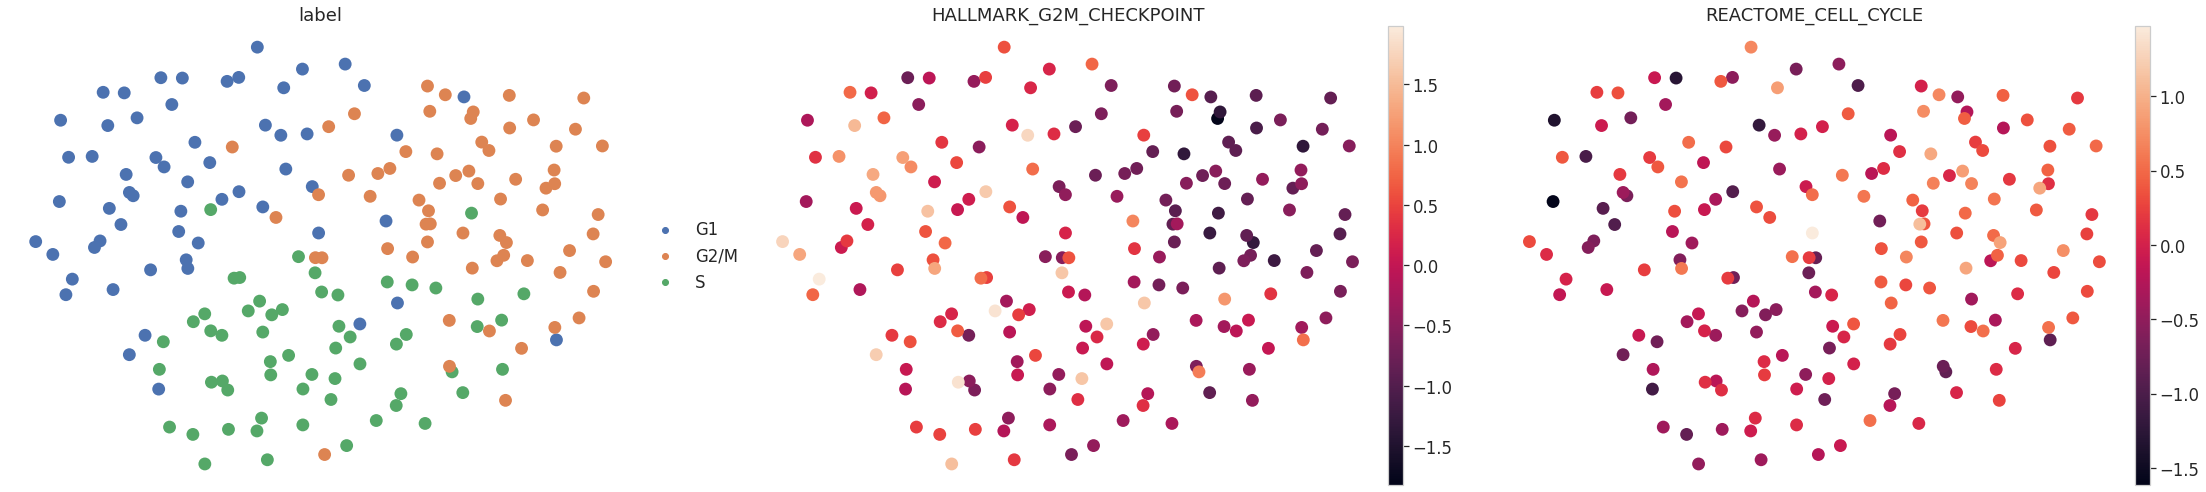

<IPython.core.display.Javascript object>

In [15]:
relevant_pathways = [
    "HALLMARK_G2M_CHECKPOINT",
    "REACTOME_CELL_CYCLE",
]

for rv in relevant_pathways:
    adata.obs[rv] = adata.obsm["X"][rv].copy()

use_rep = "X"
label = "label"

sc.pp.neighbors(adata, use_rep="X")

sc.tl.umap(adata)

sc.pl.umap(
    adata,
    color=[label] + relevant_pathways,
    frameon=False,
)

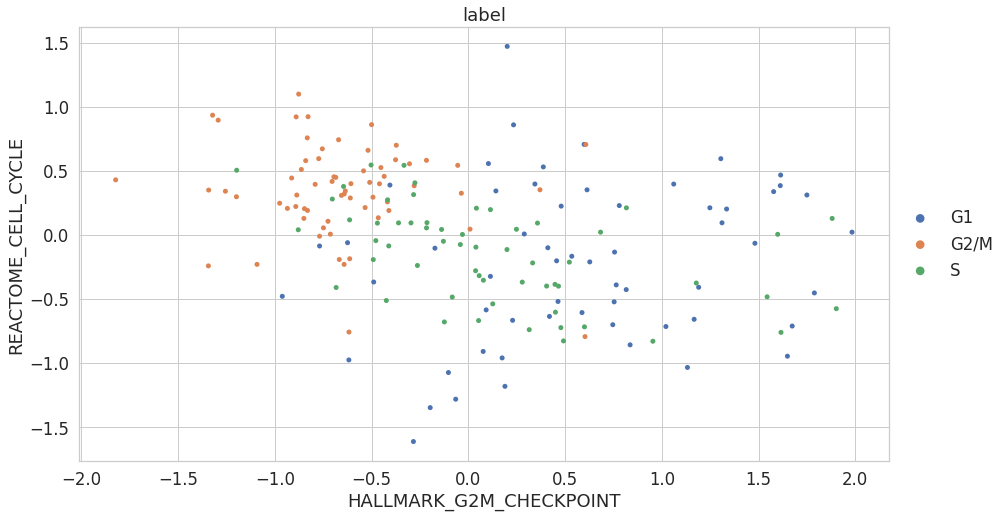

<IPython.core.display.Javascript object>

In [16]:
sc.pl.scatter(
    adata, x=relevant_pathways[0], y=relevant_pathways[1], color=label, size=100
)

In [17]:
# adata.write('adata.h5ad')

<IPython.core.display.Javascript object>

Have a look at our next [notebook](kang_evaluation.ipynb) for a more extensive downstream analysis of peripheral blood mononuclear cells from lupus patients.